A FRAMEWORK FOR AI RISK MANAGEMENT

This project is to demonstrate the retrievability of information from Knowledge Graph (KG). The KG is created for risk management in the field of Artificial Intelligence, limited to the context of chatbot application. 

In [1]:
# Importing the relevant libraries
from dotenv import load_dotenv
import os
import pandas as pd
import textwrap

# Langchain library
from langchain_community.graphs import Neo4jGraph

# Neo4j library
from neo4j import GraphDatabase

# Warning control
import warnings
warnings.filterwarnings("ignore")

Neo4j Desktop must be running on local computer

In [2]:
# Load authentication information from environment
load_dotenv('.env', override=True)
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE') or 'neo4j'

In [3]:
# Create an instance of Neo4jGraph
kg = Neo4jGraph(
    url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE
)

Data required is inserted into excel file first 

In [4]:
# Read the Excel file
excel_file = 'data-for-kg.xlsx'
df = pd.read_excel(excel_file)


In [5]:
df.shape

(28, 12)

In [6]:
df.tail()

,sector,model,application,risk_name,risk_phase,risk_impact,risk_prob,ctms_name,ctms_phase,ctms_impact,ctms_prob,stakeholder
23,Judiciary,LLM,Legal Advice Chatbot,Adversarial prompts,Deployment,moderate,moderate,Safety preprompt,Plan & Design,moderate,moderate,Management
24,Judiciary,LLM,Legal Advice Chatbot,Adversarial prompts,Deployment,moderate,moderate,Adjusting the order of pre-defined prompt,Plan & Design,moderate,moderate,Development team
25,Judiciary,LLM,Legal Advice Chatbot,Adversarial prompts,Deployment,moderate,moderate,Keyword matching,Plan & Design,moderate,moderate,Development team
26,Judiciary,LLM,Legal Advice Chatbot,Adversarial prompts,Deployment,moderate,moderate,Incorporation of guardrails,Plan & Design,moderate,moderate,Development team
27,Judiciary,LLM,Legal Advice Chatbot,Data drift,Operation & Maintenance,moderate,moderate,Evaluation metrics,Deployment,moderate,moderate,Operation team


In [7]:
# Connect to Neo4j Desktop database
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

# Create nodes and relationships in Neo4j
with driver.session() as session:
    for _, row in df.iterrows():
        query = (
            f"MERGE (c:Context {{Application: '{row['application']}', "
            f"Model: '{row['model']}', Sector: '{row['sector']}'}})"
            
            f"MERGE (r:Risk {{Name:'{row['risk_name']}', LC_Phase:'{row['risk_phase']}'}})"
            f"MERGE (r)-[:AFFECTS {{Probability:'{row['risk_prob']}', Impact:'{row['risk_impact']}'}}]->(c)"            
            
            f"MERGE (t:Treatment {{Name:'{row['ctms_name']}', LC_Phase:'{row['ctms_phase']}'}})"
            f"MERGE (t)-[:MODIFIES {{P_effect:'{row['ctms_prob']}', I_effect:'{row['ctms_impact']}'}}]->(r)"             
                        
            f"MERGE (s:Stakeholder {{Name:'{row['stakeholder']}'}})"
            f"MERGE (s)-[:RESPONSIBLE_FOR]->(t)"
        )
        session.run(query)

driver.close()

In [8]:
# Display the schema for verification
kg.refresh_schema()
print(textwrap.fill(kg.schema, 60))

Node properties: Context {Sector: STRING, Application:
STRING, Model: STRING} Risk {Name: STRING, LC_Phase: STRING}
Treatment {LC_Phase: STRING, Name: STRING} Stakeholder
{Name: STRING} Relationship properties: AFFECTS
{Probability: STRING, Impact: STRING} MODIFIES {I_effect:
STRING, P_effect: STRING} The relationships:
(:Risk)-[:AFFECTS]->(:Context)
(:Treatment)-[:MODIFIES]->(:Risk)
(:Stakeholder)-[:RESPONSIBLE_FOR]->(:Treatment)


The created schema forms a logical framework that addressed the first research question. 

In [9]:
# Generate query to Knowledge Graph involving the 'AFFECT' relationship

QUERY_RISK = kg.query("""
MATCH (n:Risk)-[r:AFFECTS]->(c:Context)
RETURN n.Name AS Risk, r.Impact, r.Probability 
""")

In [10]:
# Verify the values of QUERY_RISK

QUERY_RISK

[{'Risk': 'Data drift', 'r.Impact': 'moderate', 'r.Probability': 'moderate'},
 {'Risk': 'Adversarial prompts',
  'r.Impact': 'moderate',
  'r.Probability': 'moderate'},
 {'Risk': 'Not-suitable-for-work (NSFW) prompts',
  'r.Impact': 'moderate',
  'r.Probability': 'moderate'},
 {'Risk': 'Inference attack',
  'r.Impact': 'moderate',
  'r.Probability': 'moderate'},
 {'Risk': 'Overhead attack',
  'r.Impact': 'moderate',
  'r.Probability': 'moderate'},
 {'Risk': 'Poisoning attack',
  'r.Impact': 'moderate',
  'r.Probability': 'moderate'},
 {'Risk': 'Evasion attack',
  'r.Impact': 'moderate',
  'r.Probability': 'moderate'},
 {'Risk': 'Extraction attack',
  'r.Impact': 'moderate',
  'r.Probability': 'moderate'},
 {'Risk': 'Token limit', 'r.Impact': 'moderate', 'r.Probability': 'moderate'},
 {'Risk': 'Injection of factual errors',
  'r.Impact': 'moderate',
  'r.Probability': 'moderate'},
 {'Risk': 'Hardware overload',
  'r.Impact': 'moderate',
  'r.Probability': 'moderate'},
 {'Risk': 'Softwar

To address the second research question, the following insights are generated:
    i)    Distribution of risk according to phases of AI life cycle;
    ii)   The countermeasure (risk treatment) that could mitigate the most number of risk;
    iii)  The risk with highest priority; and
    iv)   The most effective countermeasure (in reducing the severity of a risk)

In [11]:
# First define a function called calculate risk_level 
# Then list out the calculated risk level for each risk
# Finally display the risk with highest risk level for consideration

def calculate_risk_level(impact_value, probability_value):
    risk_matrix = {
        "very high": {"very low": "very low", "low": "low", "moderate": "moderate", "high": "high", "very high": "very high"},
        "high": {"very low": "very low",  "low":  "low",  "moderate":"moderate","high":"high","very high":"very high"},
        "moderate":{"very low":" very low","low":"low","moderate":" moderate","high":" moderate"," very high ":"high"},
        'low':{" very low ":" very low ","low ":"low "," moderate ":"low "," high ":" moderate "," very high":" moderate"},
        ' very low ':{" very low ": " very low","low ":"very low","moderate":"low", "high" : "low", "very high":"low"}
    }


    try:
        risk_level = risk_matrix[impact_value][probability_value]
    except KeyError:
        print("Invalid impact or probability value.")
        return None

    return risk_level

risk_levels = {"very low": 1, "low": 2, "moderate": 3, "high": 4, "very high": 5}
highest_risk_level = "very low"
highest_risk_items = []

# Calculate risk level for each treatment-risk pair
for item in QUERY_RISK:
    risk_level = calculate_risk_level(item['r.Impact'].strip(), item['r.Probability'].strip())
    print(f"Risk level for {item['Risk']} is {risk_level}")
    # print(f"Checking risk level: {risk_level}")  # Add this line
    risk_level = risk_level.strip()
    # Check if this risk level is higher than the current highest risk level
    if risk_levels[risk_level] > risk_levels[highest_risk_level]:
        highest_risk_level = risk_level
        highest_risk_items = [item]  # Start a new list with this item
    elif risk_level == highest_risk_level:
        highest_risk_items.append(item)  # Add to the list of highest risk items

# Print out the combinations of impact and probability value that result in the highest risk level
print("\nThe following combinations of impact and probability value result in the highest risk level:")
for item in highest_risk_items:
    print(f"Risk: {item['Risk']}, Impact Value: {item['r.Impact']}, Probability Value: {item['r.Probability']}")

Risk level for Data drift is  moderate
Risk level for Adversarial prompts is  moderate
Risk level for Not-suitable-for-work (NSFW) prompts is  moderate
Risk level for Inference attack is  moderate
Risk level for Overhead attack is  moderate
Risk level for Poisoning attack is  moderate
Risk level for Evasion attack is  moderate
Risk level for Extraction attack is  moderate
Risk level for Token limit is  moderate
Risk level for Injection of factual errors is  moderate
Risk level for Hardware overload is  moderate
Risk level for Software vulnerabilities is  moderate
Risk level for Data leakage is  moderate
Risk level for Inappropriate content is  moderate
Risk level for Hallucination is high
Risk level for Harmful content is  moderate

The following combinations of impact and probability value result in the highest risk level:
Risk: Hallucination, Impact Value: high, Probability Value: high


In [12]:
# Generate query to Knowledge Graph involving the 'Risk' node

QUERY_PHASE = kg.query("""
MATCH (r:Risk)
WITH r.LC_Phase AS phase, count(*) AS count
ORDER BY count DESC
MATCH (r:Risk {LC_Phase: phase})
RETURN r.Name, r.LC_Phase
""")

In [13]:
# Verify the values in QUERY_PHASE

QUERY_PHASE

[{'r.Name': 'Harmful content', 'r.LC_Phase': 'Deployment'},
 {'r.Name': 'Hallucination', 'r.LC_Phase': 'Deployment'},
 {'r.Name': 'Inappropriate content', 'r.LC_Phase': 'Deployment'},
 {'r.Name': 'Data leakage', 'r.LC_Phase': 'Deployment'},
 {'r.Name': 'Software vulnerabilities', 'r.LC_Phase': 'Deployment'},
 {'r.Name': 'Extraction attack', 'r.LC_Phase': 'Deployment'},
 {'r.Name': 'Overhead attack', 'r.LC_Phase': 'Deployment'},
 {'r.Name': 'Inference attack', 'r.LC_Phase': 'Deployment'},
 {'r.Name': 'Not-suitable-for-work (NSFW) prompts',
  'r.LC_Phase': 'Deployment'},
 {'r.Name': 'Adversarial prompts', 'r.LC_Phase': 'Deployment'},
 {'r.Name': 'Hardware overload', 'r.LC_Phase': 'Plan & Design'},
 {'r.Name': 'Injection of factual errors', 'r.LC_Phase': 'Plan & Design'},
 {'r.Name': 'Token limit', 'r.LC_Phase': 'Plan & Design'},
 {'r.Name': 'Evasion attack', 'r.LC_Phase': 'Modelling'},
 {'r.Name': 'Poisoning attack', 'r.LC_Phase': 'Data preparation'},
 {'r.Name': 'Data drift', 'r.LC_Phas

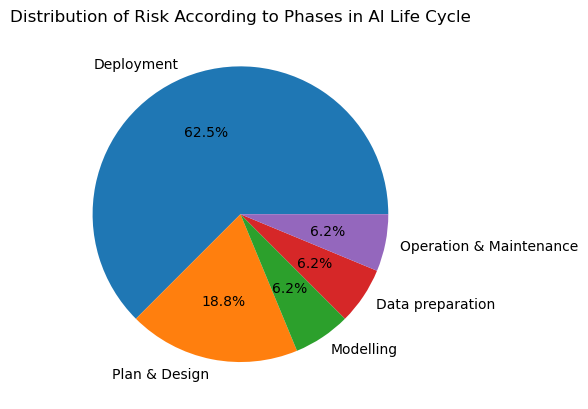

In [14]:
# Plot a pie chart to display the risk distribution
# according to the phase in AI life cycle

import matplotlib.pyplot as plt
from collections import Counter


# Count the number of each LC_Phase
phase_counts = Counter(item['r.LC_Phase'] for item in QUERY_PHASE)

# Get the phases and their counts
phases = list(phase_counts.keys())
counts = list(phase_counts.values())

# Create a pie chart
plt.pie(counts, labels=phases, autopct='%1.1f%%')
plt.title('Distribution of Risk According to Phases in AI Life Cycle')
plt.show()

In [15]:
# Generate query to Knowledge Graph that calculates
# the number of 'MODERATE' relationship to associated risks

QUERY_TREATMENT = kg.query("""
MATCH (t:Treatment)-[:MODIFIES]->(r:Risk)
WITH t.Name AS Treatment, count(distinct r.Name) AS RiskCount
ORDER BY RiskCount DESC
RETURN Treatment, RiskCount
""")

In [16]:
# Verify the value of QUERY_TREATMENT

QUERY_TREATMENT

[{'Treatment': 'Incorporation of guardrails', 'RiskCount': 5},
 {'Treatment': 'Detection', 'RiskCount': 3},
 {'Treatment': 'Data minimization', 'RiskCount': 2},
 {'Treatment': 'Safety preprompt', 'RiskCount': 2},
 {'Treatment': 'Intervention', 'RiskCount': 1},
 {'Treatment': 'Reranking strategy', 'RiskCount': 1},
 {'Treatment': 'Learning from human feedback', 'RiskCount': 1},
 {'Treatment': 'Exploiting external knowledge', 'RiskCount': 1},
 {'Treatment': 'Data anonymization', 'RiskCount': 1},
 {'Treatment': 'Control-flow integrity', 'RiskCount': 1},
 {'Treatment': 'Hardware error correction', 'RiskCount': 1},
 {'Treatment': 'Monitoring of utilization', 'RiskCount': 1},
 {'Treatment': 'Use local models', 'RiskCount': 1},
 {'Treatment': 'Watermarking', 'RiskCount': 1},
 {'Treatment': 'Traffic monitoring', 'RiskCount': 1},
 {'Treatment': 'Adversarial training', 'RiskCount': 1},
 {'Treatment': 'Differential privacy', 'RiskCount': 1},
 {'Treatment': 'Keyword matching', 'RiskCount': 1},
 {'T

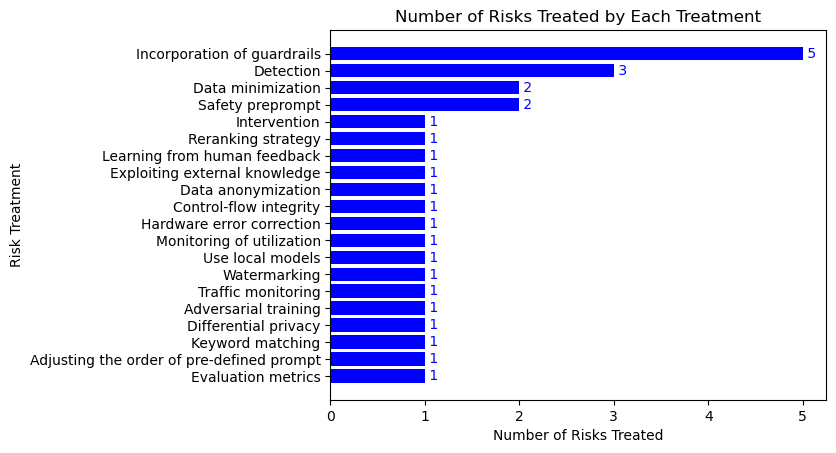

In [17]:
# Plot a histogram to show the treatment that tackles the most risks

import matplotlib.pyplot as plt

# Sort the list in descending order of RiskCount
QUERY_TREATMENT.sort(key=lambda x: x['RiskCount'], reverse=True)

# Get the treatments and their counts
treatments = [item['Treatment'] for item in QUERY_TREATMENT]
counts = [item['RiskCount'] for item in QUERY_TREATMENT]

# Create a bar chart
plt.barh(treatments, counts, color='blue')

# Label the bars with their counts
for i, v in enumerate(counts):
    plt.text(v, i, " "+str(v), color='blue', va='center')

plt.xlabel('Number of Risks Treated')
plt.ylabel('Risk Treatment')
plt.title('Number of Risks Treated by Each Treatment')
plt.gca().invert_yaxis()  # invert the y-axis to have the treatment with the most risks at the top
plt.show()

In [18]:
# Generate query to Knowledge Graph that returns the values
# for the properties I_effect and P_effect of each MODIFIES
# relationship between Treatment and Risk

QUERY_MODIFIES = kg.query("""
  MATCH (r:Risk)<-[m:MODIFIES]-(t:Treatment) 
  RETURN t.Name AS Treatment, m.I_effect AS Impact_effect, m.P_effect AS Probability_effect, r.Name AS Risk
""")


In [19]:
# Verify the values for QUERY_MODIFIES

QUERY_MODIFIES

[{'Treatment': 'Intervention',
  'Impact_effect': 'moderate',
  'Probability_effect': 'moderate',
  'Risk': 'Harmful content'},
 {'Treatment': 'Detection',
  'Impact_effect': 'high',
  'Probability_effect': 'moderate',
  'Risk': 'Harmful content'},
 {'Treatment': 'Detection',
  'Impact_effect': 'high',
  'Probability_effect': 'moderate',
  'Risk': 'Hallucination'},
 {'Treatment': 'Reranking strategy',
  'Impact_effect': 'moderate',
  'Probability_effect': 'moderate',
  'Risk': 'Hallucination'},
 {'Treatment': 'Learning from human feedback',
  'Impact_effect': 'moderate',
  'Probability_effect': 'moderate',
  'Risk': 'Hallucination'},
 {'Treatment': 'Exploiting external knowledge',
  'Impact_effect': 'high',
  'Probability_effect': 'high',
  'Risk': 'Hallucination'},
 {'Treatment': 'Data minimization',
  'Impact_effect': 'moderate',
  'Probability_effect': 'moderate',
  'Risk': 'Inappropriate content'},
 {'Treatment': 'Data anonymization',
  'Impact_effect': 'moderate',
  'Probability_e

In [20]:
# First define a function called calculate_treatment_effect 
# Then list out the calculated treatment_effect for each treatment
# Finally display the treatment with the highest treatment_effect 

def calculate_treatment_effect(impact_value, probability_value):
    effect_matrix = {
        "very high": {"very low": "very low", "low": "low", "moderate": "moderate", "high": "high", "very high": "very high"},
        "high": {"very low": "very low",  "low":  "low",  "moderate":"moderate","high":"high","very high":"very high"},
        "moderate":{"very low":" very low","low":"low","moderate":" moderate","high":" moderate"," very high ":"high"},
        'low':{" very low ":" very low ","low ":"low "," moderate ":"low "," high ":" moderate "," very high":" moderate"},
        ' very low ':{" very low ": " very low","low ":"very low","moderate":"low", "high" : "low", "very high":"low"}
    }


    try:
        treatment_effect = effect_matrix[impact_value][probability_value]
    except KeyError:
        print("Invalid impact or probability value.")
        return None

    return treatment_effect

treatment_definition = {"very low": 1, "low": 2, "moderate": 3, "high": 4, "very high": 5}
highest_treatment_level = "very low"
highest_treatment_items = []

# Calculate risk level for each treatment-risk pair
for item in QUERY_MODIFIES:
    treatment_effect = calculate_treatment_effect(item['Impact_effect'].strip(), item['Probability_effect'].strip())
    print(f"Treatment effectiveness for {item['Treatment']} is {treatment_effect}")
    # Ensure no empty characters before and after the text
    treatment_effect = treatment_effect.strip()
    
    # Check if this risk level is higher than the current highest risk level
    if treatment_definition[treatment_effect] > treatment_definition[highest_treatment_level]:
        highest_treatment_level = treatment_effect
        highest_treatment_items = [item]  # Start a new list with this item
    elif treatment_effect == highest_treatment_level:
        highest_treatment_items.append(item)  # Add to the list of highest risk items

# Print out the combinations of impact and probability value that result in the highest risk level
print("\nThe following combinations of impact effect and probability effect result in the most effective treatment:")
for item in highest_treatment_items:
    print(f"Treatment Name: {item['Treatment']}, Impact Effect: {item['Impact_effect']}, Probability Effect: {item['Probability_effect']}")

Treatment effectiveness for Intervention is  moderate
Treatment effectiveness for Detection is moderate
Treatment effectiveness for Detection is moderate
Treatment effectiveness for Reranking strategy is  moderate
Treatment effectiveness for Learning from human feedback is  moderate
Treatment effectiveness for Exploiting external knowledge is high
Treatment effectiveness for Data minimization is  moderate
Treatment effectiveness for Data anonymization is  moderate
Treatment effectiveness for Incorporation of guardrails is  moderate
Treatment effectiveness for Data minimization is  moderate
Treatment effectiveness for Control-flow integrity is  moderate
Treatment effectiveness for Hardware error correction is  moderate
Treatment effectiveness for Monitoring of utilization is  moderate
Treatment effectiveness for Safety preprompt is  moderate
Treatment effectiveness for Use local models is  moderate
Treatment effectiveness for Watermarking is  moderate
Treatment effectiveness for Incorpo

End of the code for this project